# PID controller with a brake

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
b1, b2, b3, b4, s0, s1, s2 = ?

while(t < T):

    # decides whether brake is needed
    if b1*d+b2>0 and b3*d+4>0 {
        brakev = -1
    } else {
        brakev = 1
    }

    d = ang - 3.14
    torq = s0 *  d + s1 * v + s2 * id + brakev + gauss(0, 0.5);
    id = 0.9*id + d
    oldv= v 

    v = v + 0.01*torq + gauss(0, 0.5)
    ang = ang + 0.05*(v + oldv) + gauss(0, 0.1)

    if ang > 6.28 {
        ang = ang - 6.28
    } elif ang < 0 {
        ang = and + 6.28
    }  
```

### Original Model

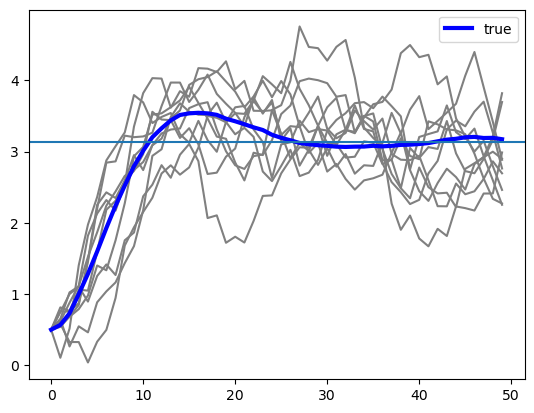

In [41]:
from cps.original_models import *

orig_params = {'T': 50,
               'init_ang': 0.5,
               's0': 46.,
               's1': -23.,
               's2': 0.}

target = 3.14
T = orig_params['T']
        

orig_traj = generate_traj(pid, 500, orig_params)

plot_traj_set(orig_traj, single_traj=10, label='true')
plt.axhline(y=target)


### SOGA program

In [42]:
from optimization import *
import pandas as pd
torch.set_default_dtype(torch.float64)

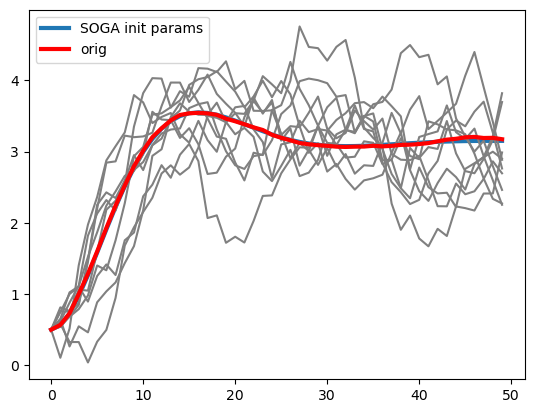

In [43]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

# creates the cfg for the SOGA model
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s0':46., 's1':-23., 's2':0.}
params_dict = initialize_params(params)

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')
y = []
y_var = []
for i in range(49):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('ang['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('ang['+ str(i) +']'), output_dist.var_list.index('ang['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('PID_init.csv', index=False)

s0: 46.849999998072974 s1: -23.849999997177424 s2: -0.8499999729130738  loss: 3093.3936981433335
s0: 303.32546421666495 s1: -200.1439888515354 s2: -54.45289615694866  loss: 1723.242987449281
s0: 545.2153033803687 s1: -199.99544955878062 s2: -23.24186835137041  loss: 661.9336537723384
s0: 764.9920386550824 s1: -199.99899052111957 s2: -6.939697633419197  loss: -160.73912558937025
s0: 966.2739662670081 s1: -199.99982217108447 s2: -1.423338631295542  loss: -796.2448123055701
s0: 1149.8406670807992 s1: -200.00563493637708 s2: -0.23576833253767965  loss: -1277.5386633936782
s0: 1315.686230481356 s1: -199.99999303856 s2: -0.013116860872863187  loss: -1631.7616228423674
s0: 1463.369108747042 s1: -199.99999706006292 s2: 0.004139284393378526  loss: -1882.7747173956197
s0: 1592.2970798275662 s1: -199.9999978979266 s2: 0.0029685189056875777  loss: -2052.2934975094468
s0: 1701.909583633211 s1: -199.99999915923243 s2: 0.0010971007429974578  loss: -2160.0332726904207
Optimization performed in  800.46

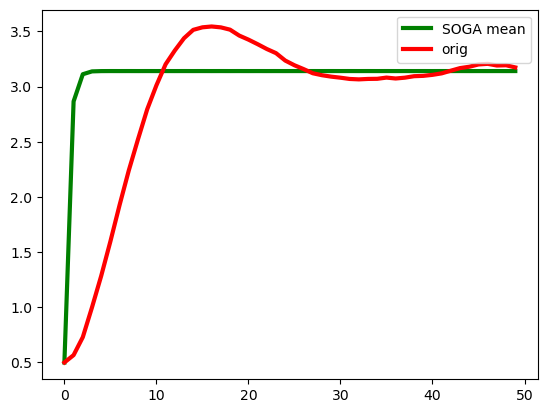

In [50]:
# Trying with neg_log_likelihood as loos

# Optimization in SOGA

# We start from the same initial parameters and try to improve them

# Define loss
observed_traj = target*torch.ones(100, T)
loss = lambda dist : neg_log_likelihood(observed_traj, dist, idx=list(range(1,T)))

# cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s0':46., 's1':-23., 's2':0.}
params_dict = initialize_params(params)

# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=3000, lr=0.85)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')
y = []
y_var = []
for i in range(49):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('ang['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('ang['+ str(i) +']'), output_dist.var_list.index('ang['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('PID_opt.csv', index=False)

In [51]:
#export orig_traj to csv
import pandas as pd
#consider only 40 trajectories from time 0 to 30
plot_trajectories = observed_traj[:40, 0:49]
#transpose the array so that each row is a time step and each column is a trajectory
plot_trajectories = plot_trajectories.T

df = pd.DataFrame(plot_trajectories)
df.to_csv('PID_orig_traj.csv', index=False)

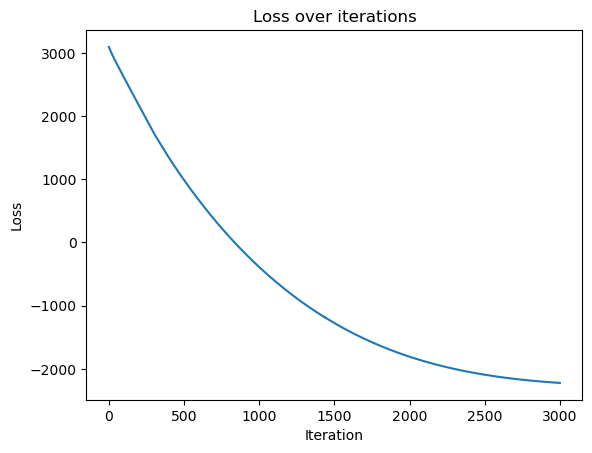

In [52]:
# export loss_list to csv
df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('PID_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

## Pyro

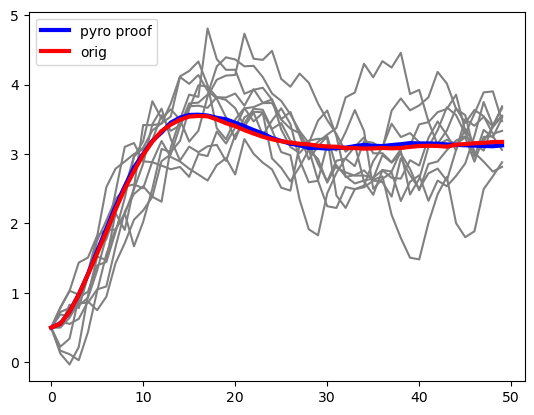

In [5]:
from cps.pyro_models import *

# This is to check that the model works as expected for the right values of the parameters

T = 50
init_ang = 0.5

def pid_pyro_proof(batch_size):

    # Sample parameters
    s0 = pyro.sample("s0", dist.Normal(46., 0.1))
    s1 = pyro.sample("s1", dist.Normal(-23, 0.1))
    s2 = pyro.sample("s2", dist.Normal(0., 0.1))

    target = 3.14
    dt = 0.1
    inertia = 10
    decay = 0.9

    traj_list = []
    v = torch.zeros(batch_size)
    ang = torch.ones(batch_size) * init_ang
    id = torch.zeros(batch_size)

    noise = dist.Normal(0., 0.25)
    noise_ang = dist.Normal(0., 0.25)

    for i in range(T):
        traj_list.append(ang)
        d = target - ang
        torq = s0 * d + s1 * v + s2 * id
        id = decay * id + d * dt
        oldv = v
        v = v + (dt / inertia) * torq + noise.rsample([batch_size])
        ang = ang + (dt / 2) * (v + oldv) + noise_ang.rsample([batch_size])

    traj = torch.stack(traj_list, dim=1)

    return traj

pyro_traj = pid_pyro_proof(batch_size=500)

plot_traj_set(pyro_traj, single_traj=10, label='pyro proof')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')

### MCMC

In [6]:
observed_traj = target*torch.ones(100, T) 

init_params = {'T': 50,
               'init_ang': 0.5,
               's0': 46.,
               's1': -23.,
               's2': 0.}


pid_pyro = create_pid_pyro(init_params, eps=2.0)

posterior_samples = run_NUTS(pid_pyro, observed_traj, num_samples=10000, warmup_steps=100, adapt_step_size=True, step_size=1e-4)


Sample: 100%|██████████| 10100/10100 [00:49, 204.07it/s, step size=4.58e-17, acc. prob=0.000]


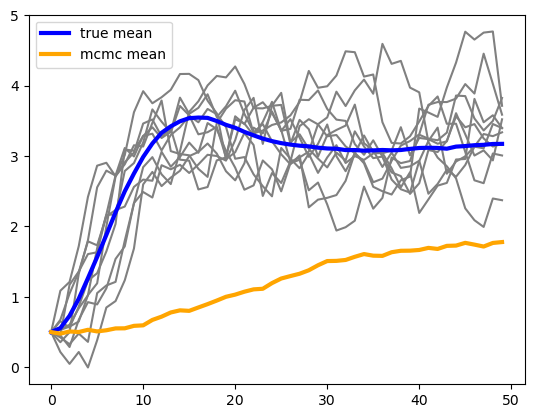

In [7]:
### generate trajectories for posterior estimations and plots the mean trajectory
mcmc_params = {'T': 50,
               'init_ang': 0.5,
               's0': posterior_samples['s0'].mean().item(),
               's1': posterior_samples['s1'].mean().item(),
               's2': posterior_samples['s2'].mean().item()}


mcmc_traj = generate_traj(pid, 100, mcmc_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_traj, single_traj=0, color='orange', label='mcmc mean')

### VI Inference

In [8]:
observed_traj = target*torch.ones(100, T) + 0.5*torch.randn(100, T)

init_params = {'T': 50,
               'init_ang': 0.5,
               's0': torch.tensor(46.),
               's1': torch.tensor(-23.),
               's2': torch.tensor(0.)}

Step 0: Loss = 30999.631353619196
Step 100: Loss = 30753.450605032926
Step 200: Loss = 30639.85237468846
Step 300: Loss = 30608.275644397458
Step 400: Loss = 30531.500973338174
Step 500: Loss = 30433.2288528372
Step 600: Loss = 30474.398231800096
Step 700: Loss = 30423.921351278255
Step 800: Loss = 30430.24159703836
Step 900: Loss = 30310.330324475413
Optimization performed in 52.96 seconds


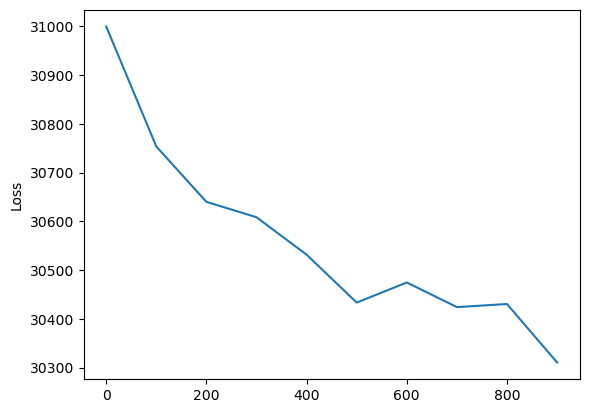

In [9]:
pid_pyro = create_pid_pyro(init_params, eps=1.0)

pid_guide = create_pid_guide(init_params)

run_SVI(pid_pyro, pid_guide, orig_traj, num_steps=1000, lr=0.05, num_particles=10, loss_plot=True)

Optimized s0: 75.22301496694658, s1: -43.66906048958729, s2: 23.737270718952473


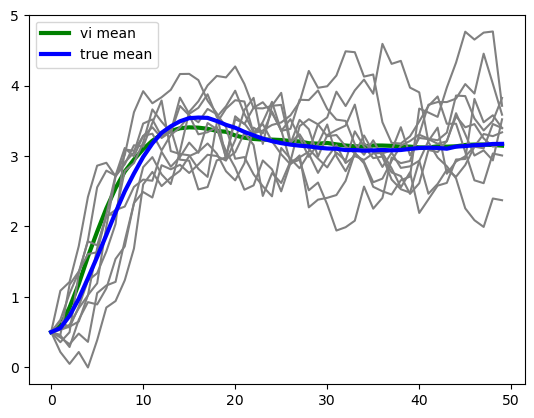

In [10]:
# Retrieve optimized parameters
vi_s0 = pyro.param("s0_loc").item()
vi_s1 = pyro.param("s1_loc").item()
vi_s2 = pyro.param("s2_loc").item()

print(f"Optimized s0: {vi_s0}, s1: {vi_s1}, s2: {vi_s2}")

# plot

vi_traj = generate_traj(pid, 500, {'T': 50,
                                   'init_ang': 0.5,
                                   's0': vi_s0,
                                   's1': vi_s1,
                                   's2': vi_s2})

plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')


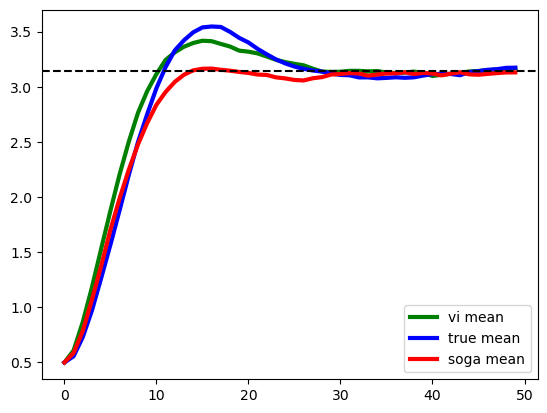

In [11]:
vi_traj = generate_traj(pid, 500, {'T': 50,
                                   'init_ang': 0.5,
                                   's0': vi_s0,
                                   's1': vi_s1,
                                   's2': vi_s2})

soga_traj = generate_traj(pid, 500, {'T': 50,
                                     'init_ang': 0.5,
                                     's0': params_dict['s0'].item(),
                                     's1': params_dict['s1'].item(),
                                     's2': params_dict['s2'].item()})

plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=0, color='blue', label='true mean')
plot_traj_set(soga_traj, single_traj=0, color='red', label='soga mean')
plt.axhline(y=target, color='black', linestyle='--', label='target')

In [ ]:
# Retrieve optimized mean and variance of paramters from VI and calculate the negative log likelihood of the observed data given the optimized parameters
vi_s0_mean = pyro.param("s0_loc").item()
vi_s0_std = pyro.param("s0_scale").item()
vi_s1_mean = pyro.param("s1_loc").item()
vi_s1_std = pyro.param("s1_scale").item()
vi_s2_mean = pyro.param("s2_loc").item()
vi_s2_std = pyro.param("s2_scale").item()
print(f"VI optimized parameters: s0 = {vi_s0_mean} ± {vi_s0_std}, s1 = {vi_s1_mean} ± {vi_s1_std}, s2 = {vi_s2_mean} ± {vi_s2_std}")

#now calculate the negative log likelihood of the observed data given the optimized parameters
